In [1]:
%%time
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install git+git://github.com/geopandas/geopandas.git
!pip install folium
!pip install -U scikit-learn
!pip install seaborn --upgrade


zsh:1: command not found: apt
zsh:1: command not found: apt
zsh:1: command not found: apt
zsh:1: command not found: apt
  Cloning git://github.com/geopandas/geopandas.git to /private/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/pip-req-build-seku178y
  error: subprocess-exited-with-error
  
  × git version did not run successfully.
  │ exit code: 69
  ╰─> [2 lines of output]
      You have not agreed to the Xcode license agreements. Please run 'sudo xcodebuild -license' from within a Terminal window to review and agree to the Xcode and Apple SDKs license.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
error: subprocess-exited-with-error

× git version did not run successfully.
│ exit code: 69
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

[notic

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import requests
import seaborn as sns

print(sns.__version__)

#our dataset link (real time)
url = 'https://services.arcgis.com/CXBb7LAjgIIdcsPt/arcgis/rest/services/CAS_Data_Public/FeatureServer/0/query'

# Function to fetch all records 
def fetch_all_records(url, max_records=2000):
    features = []  
    offset = 0  

    while True:
        
        params = {
            'outFields': '*',
            'where': '1=1',
            'f': 'geojson',
            'resultOffset': offset,
            'resultRecordCount': max_records
        }

        
        response = requests.get(url, params=params)
        response.raise_for_status()  
        data = response.json()

      
        features.extend(data['features'])

       
        if len(data['features']) < max_records:
            break  

        
        offset += max_records

    return features


features = fetch_all_records(url)


crs = {'init': 'epsg:3851'}  # It is the coordinate reference system  for New Zealand
gdf = gpd.GeoDataFrame.from_features(features, crs=crs)


print(gdf.head())


print(gdf.shape)


0.13.2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


                  geometry  OBJECTID  advisorySpeed  areaUnitID  bicycle  \
0  POINT (176.365 -38.009)  73611980            NaN    538820.0      0.0   
1  POINT (176.511 -40.076)  73611981            NaN    549602.0      0.0   
2  POINT (175.258 -37.773)  73611982            NaN    528800.0      0.0   
3  POINT (174.946 -37.029)  73611983            NaN    523911.0      0.0   
4  POINT (176.744 -39.632)  73611984            NaN    545842.0      0.0   

   bridge  bus  carStationWagon  cliffBank crashDirectionDescription  ...  \
0     0.0  0.0              1.0        0.0                     South  ...   
1     0.0  0.0              2.0        0.0                     South  ...   
2     NaN  0.0              2.0        NaN                      Null  ...   
3     0.0  0.0              1.0        0.0                     North  ...   
4     NaN  0.0              1.0        NaN                      East  ...   

  train tree truck unknownVehicleType  urban vanOrUtility  vehicle  \
0   0.0  0

In [4]:

print(gdf.columns)


Index(['geometry', 'OBJECTID', 'advisorySpeed', 'areaUnitID', 'bicycle',
       'bridge', 'bus', 'carStationWagon', 'cliffBank',
       'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1',
       'crashLocation2', 'crashRoadSideRoad', 'crashSeverity',
       'crashSHDescription', 'crashYear', 'debris', 'directionRoleDescription',
       'ditch', 'fatalCount', 'fence', 'flatHill', 'guardRail', 'holiday',
       'houseOrBuilding', 'intersection', 'kerb', 'light', 'meshblockId',
       'minorInjuryCount', 'moped', 'motorcycle', 'NumberOfLanes',
       'objectThrownOrDropped', 'otherObject', 'otherVehicleType', 'overBank',
       'parkedVehicle', 'pedestrian', 'phoneBoxEtc', 'postOrPole', 'region',
       'roadCharacter', 'roadLane', 'roadSurface', 'roadworks', 'schoolBus',
       'seriousInjuryCount', 'slipOrFlood', 'speedLimit', 'strayAnimal',
       'streetLight', 'suv', 'taxi', 'temporarySpeedLimit', 'tlaId', 'tlaName',
       'trafficControl', 'trafficIsland', 'traffic

Exploratory Data Analysis


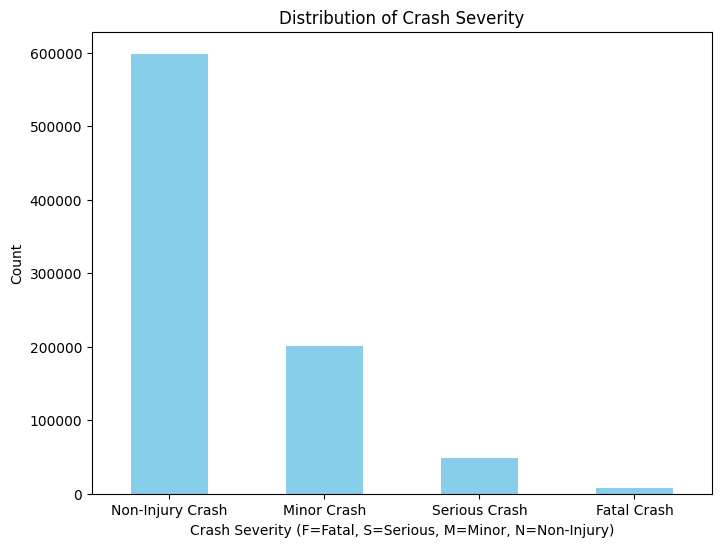

In [5]:

plt.figure(figsize=(8, 6))
gdf['crashSeverity'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Crash Severity")
plt.xlabel("Crash Severity (F=Fatal, S=Serious, M=Minor, N=Non-Injury)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


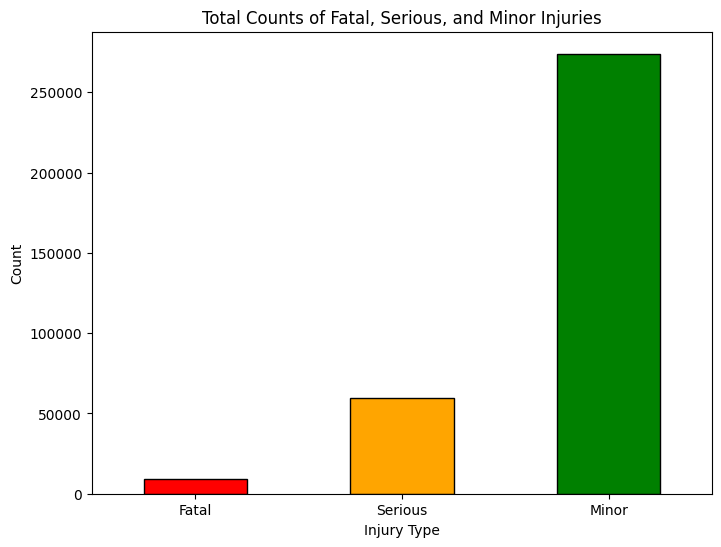

In [6]:

injury_counts = gdf[['fatalCount', 'seriousInjuryCount', 'minorInjuryCount']].sum()
injury_counts.plot(kind='bar', figsize=(8, 6), color=['red', 'orange', 'green'], edgecolor='black')
plt.title("Total Counts of Fatal, Serious, and Minor Injuries")
plt.xlabel("Injury Type")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=['Fatal', 'Serious', 'Minor'], rotation=0)
plt.show()


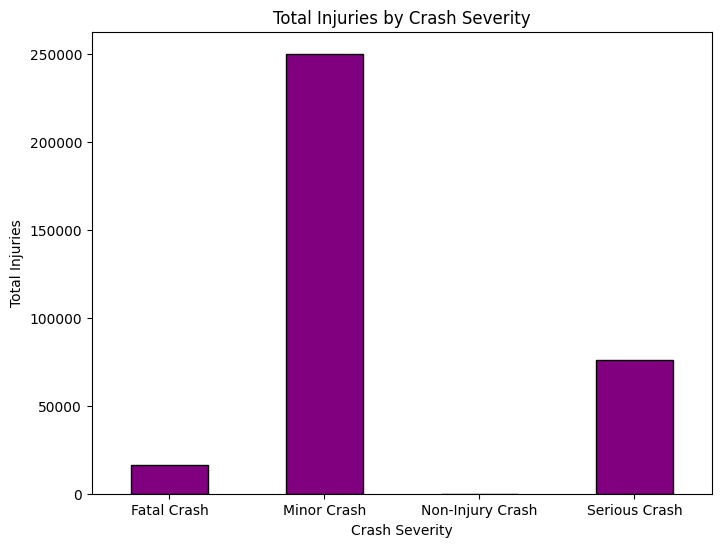

In [7]:

gdf['totalInjuries'] = gdf['fatalCount'] + gdf['seriousInjuryCount'] + gdf['minorInjuryCount']


severity_injuries = gdf.groupby('crashSeverity')['totalInjuries'].sum()
severity_injuries.plot(kind='bar', color='purple', figsize=(8, 6), edgecolor='black')
plt.title("Total Injuries by Crash Severity")
plt.xlabel("Crash Severity")
plt.ylabel("Total Injuries")
plt.xticks(rotation=0)
plt.show()


<Figure size 1200x600 with 0 Axes>

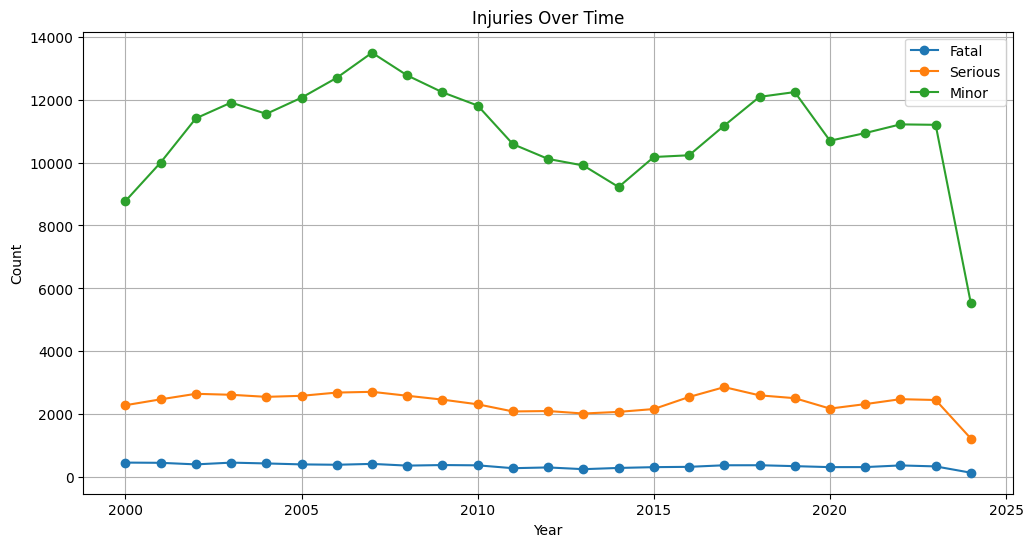

In [8]:

yearly_injuries = gdf.groupby('crashYear')[['fatalCount', 'seriousInjuryCount', 'minorInjuryCount']].sum()


plt.figure(figsize=(12, 6))
yearly_injuries.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Injuries Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Fatal", "Serious", "Minor"])
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

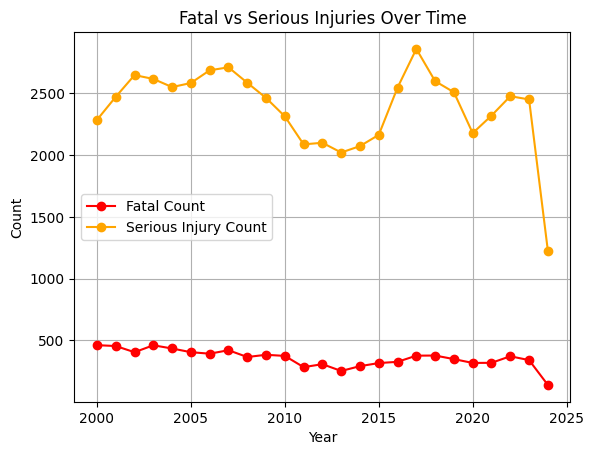

In [9]:

injury_comparison = gdf.groupby('crashYear')[['fatalCount', 'seriousInjuryCount']].sum()

plt.figure(figsize=(12, 6))
injury_comparison.plot(kind='line', marker='o', color=['red', 'orange'])
plt.title("Fatal vs Serious Injuries Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(["Fatal Count", "Serious Injury Count"])
plt.grid(True)
plt.show()


road-related crash factors

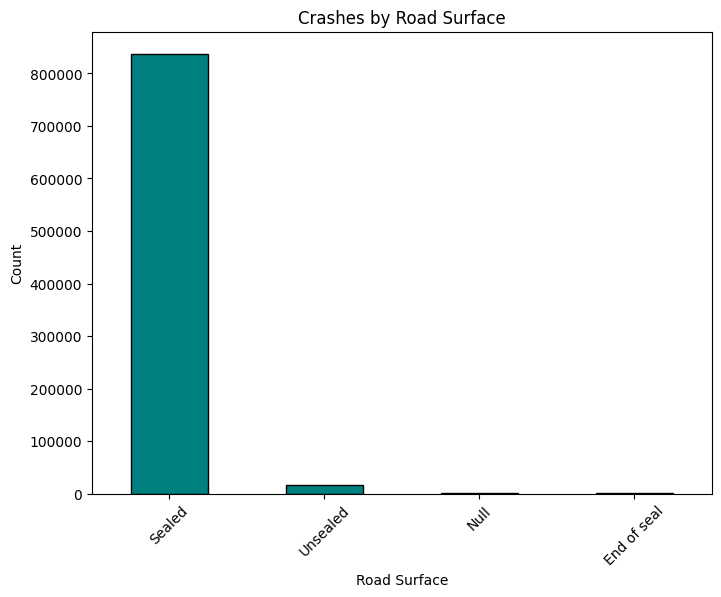

In [10]:

plt.figure(figsize=(8, 6))
gdf['roadSurface'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title("Crashes by Road Surface")
plt.xlabel("Road Surface")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


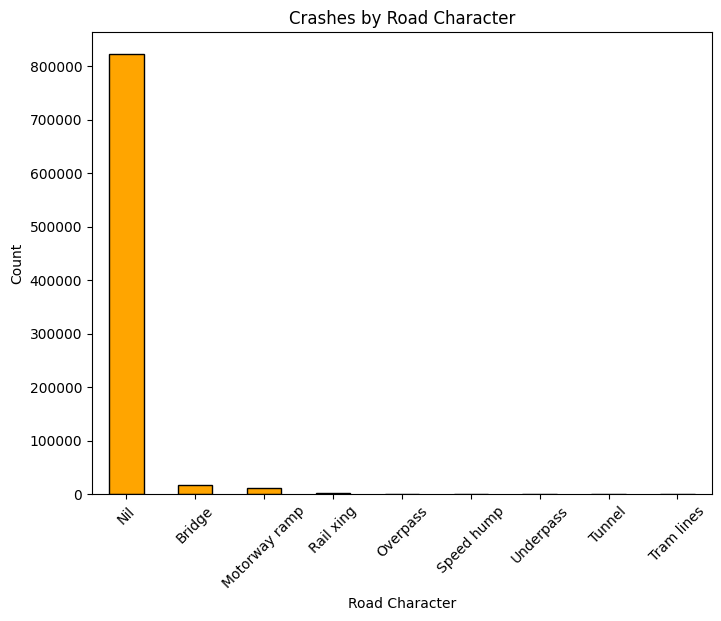

In [11]:

plt.figure(figsize=(8, 6))
gdf['roadCharacter'].value_counts().plot(kind='bar', color='orange', edgecolor='black')
plt.title("Crashes by Road Character")
plt.xlabel("Road Character")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


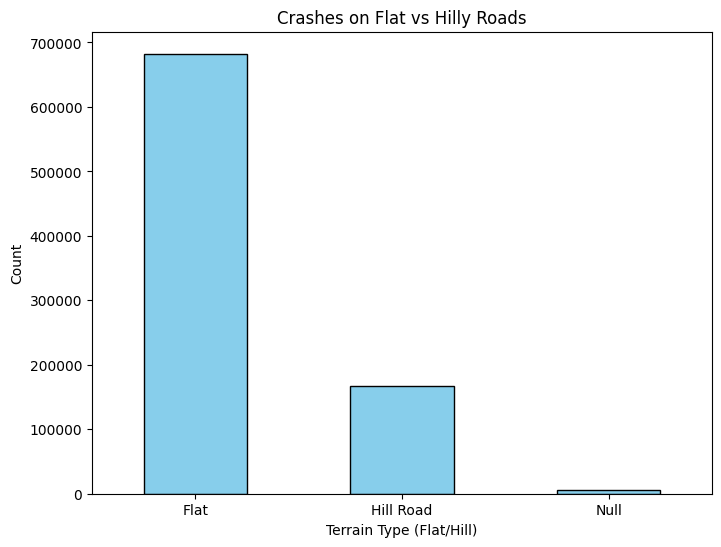

In [12]:

plt.figure(figsize=(8, 6))
gdf['flatHill'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Crashes on Flat vs Hilly Roads")
plt.xlabel("Terrain Type (Flat/Hill)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


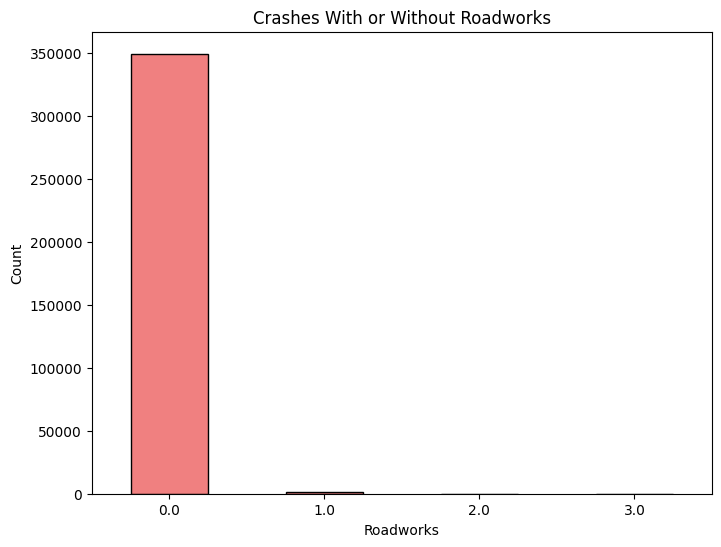

In [13]:

plt.figure(figsize=(8, 6))
gdf['roadworks'].value_counts().plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Crashes With or Without Roadworks")
plt.xlabel("Roadworks")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()



**traffic**

/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/592554330.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="speedLimit", y="fatalCount", data=gdf, ci=None, color='teal')


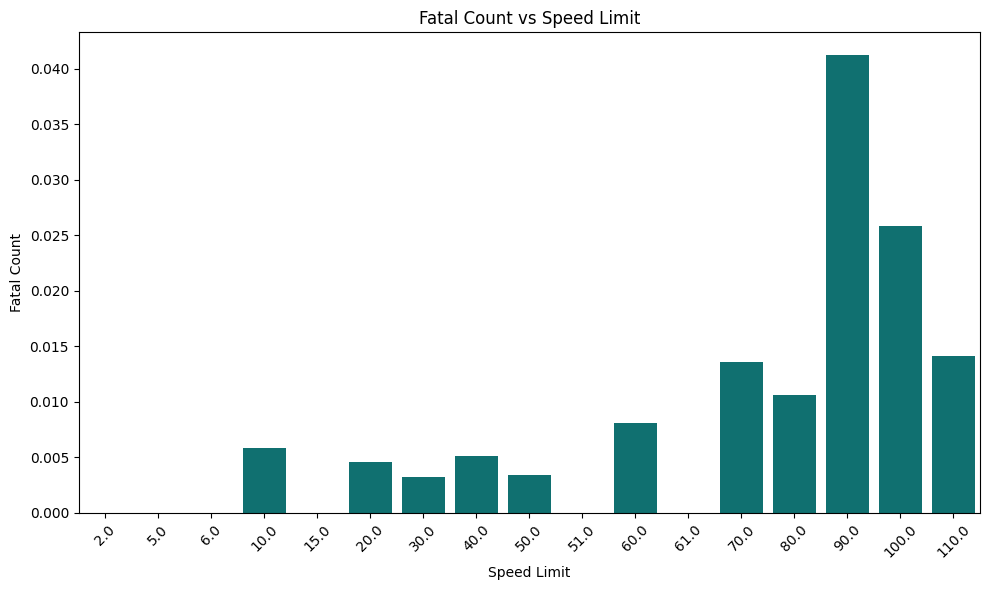

In [14]:

plt.figure(figsize=(10, 6))
sns.barplot(x="speedLimit", y="fatalCount", data=gdf, ci=None, color='teal')
plt.title("Fatal Count vs Speed Limit")
plt.xlabel("Speed Limit")
plt.ylabel("Fatal Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/2291390220.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="advisorySpeed", y="crashSeverityNumeric", data=gdf, ci=None, color='purple')


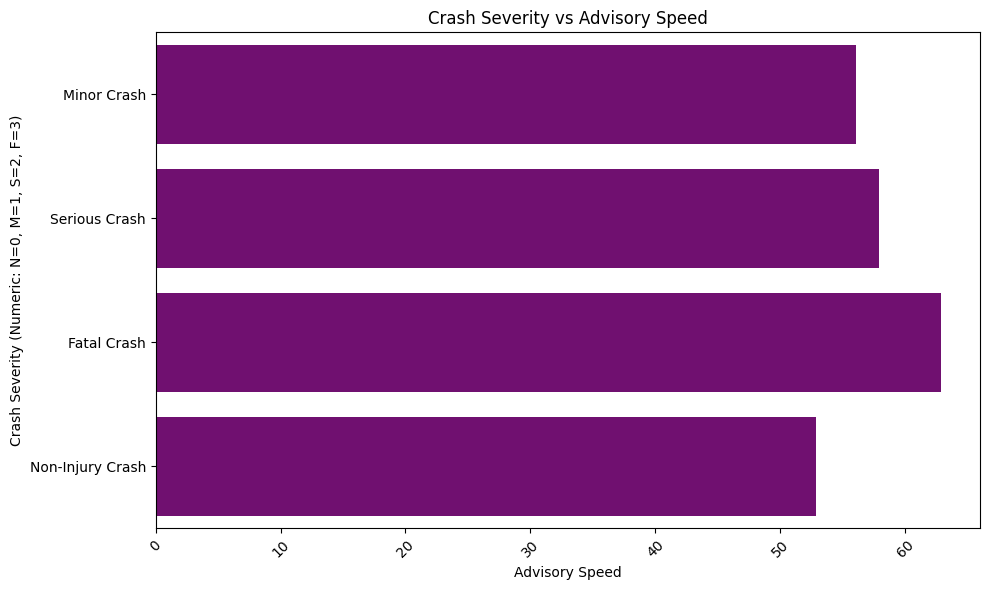

In [15]:

severity_mapping = {'N': 0, 'M': 1, 'S': 2, 'F': 3}  
gdf['crashSeverityNumeric'] = gdf['crashSeverity'].replace(severity_mapping)


plt.figure(figsize=(10, 6))
sns.barplot(x="advisorySpeed", y="crashSeverityNumeric", data=gdf, ci=None, color='purple')
plt.title("Crash Severity vs Advisory Speed")
plt.xlabel("Advisory Speed")
plt.ylabel("Crash Severity (Numeric: N=0, M=1, S=2, F=3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


weather

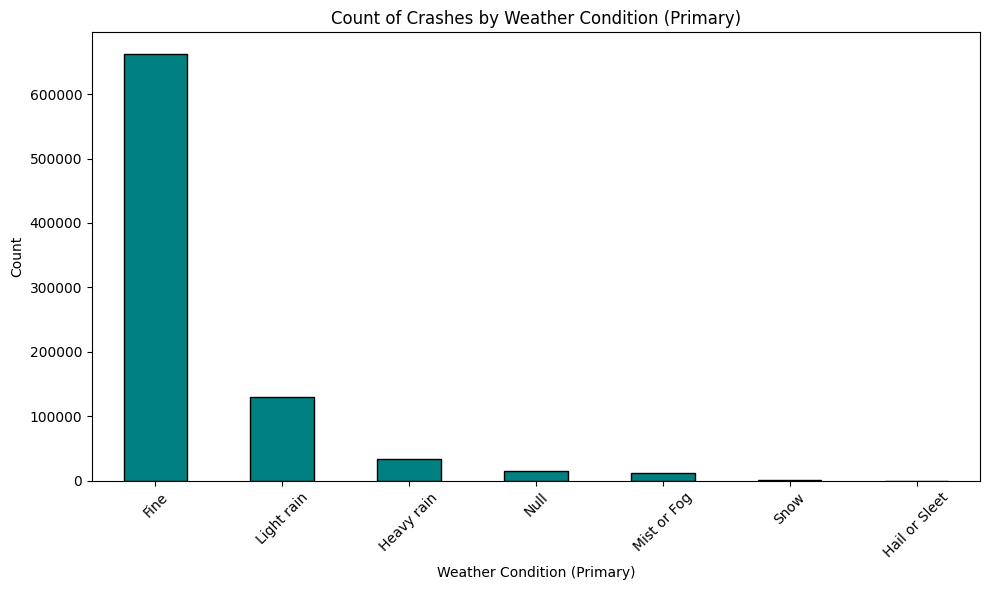

In [16]:

plt.figure(figsize=(10, 6))
gdf['weatherA'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title("Count of Crashes by Weather Condition (Primary)")
plt.xlabel("Weather Condition (Primary)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


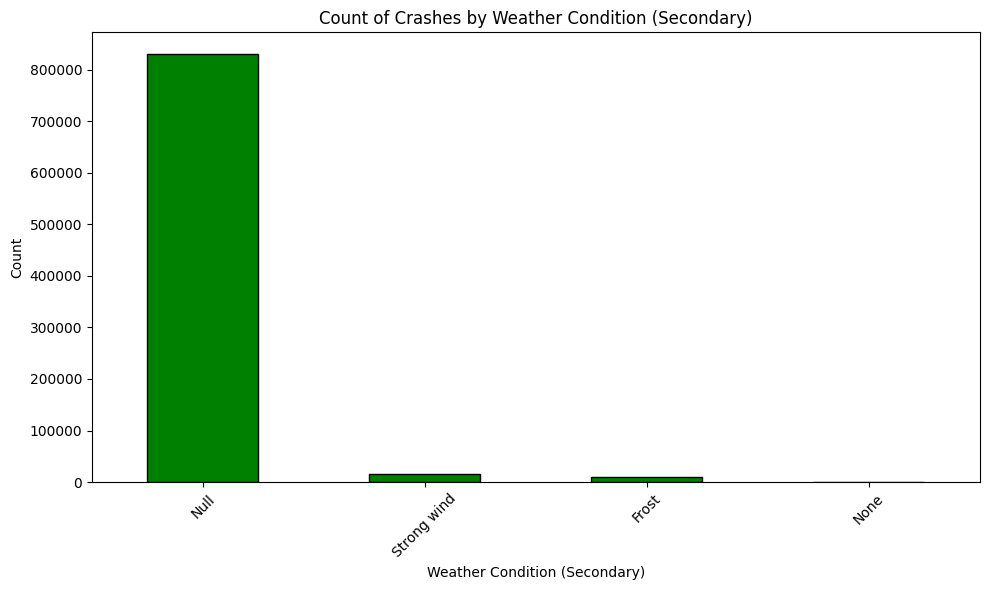

In [17]:

plt.figure(figsize=(10, 6))
gdf['weatherB'].value_counts().plot(kind='bar', color='green', edgecolor='black')
plt.title("Count of Crashes by Weather Condition (Secondary)")
plt.xlabel("Weather Condition (Secondary)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/1615646326.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="weatherA", y="fatalCount", data=gdf, ci=None, palette="Blues_d")
/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/1615646326.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weatherA", y="fatalCount", data=gdf, ci=None, palette="Blues_d")


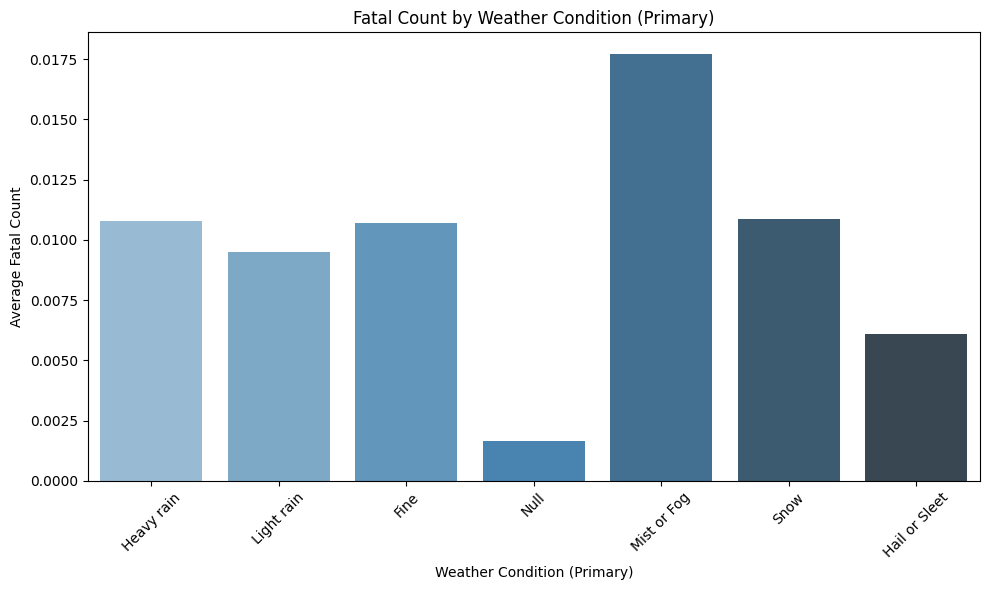

In [18]:

plt.figure(figsize=(10, 6))
sns.barplot(x="weatherA", y="fatalCount", data=gdf, ci=None, palette="Blues_d")
plt.title("Fatal Count by Weather Condition (Primary)")
plt.xlabel("Weather Condition (Primary)")
plt.ylabel("Average Fatal Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/749596255.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="weatherB", y="fatalCount", data=gdf, ci=None, palette="Purples_d")
/var/folders/23/hxkfjnkj7999w8nd93z29zbc0000gn/T/ipykernel_38365/749596255.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weatherB", y="fatalCount", data=gdf, ci=None, palette="Purples_d")


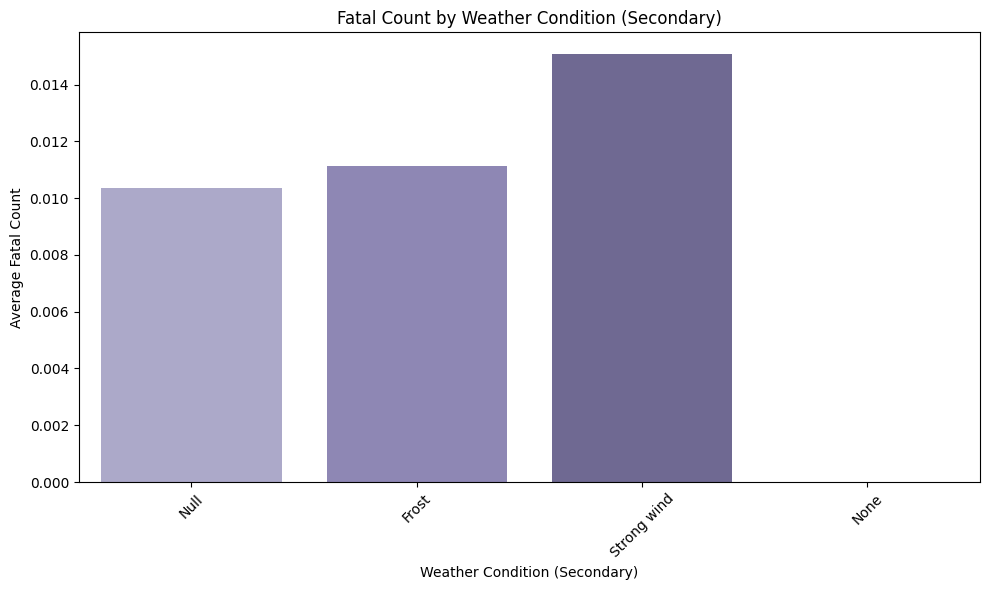

In [19]:

plt.figure(figsize=(10, 6))
sns.barplot(x="weatherB", y="fatalCount", data=gdf, ci=None, palette="Purples_d")
plt.title("Fatal Count by Weather Condition (Secondary)")
plt.xlabel("Weather Condition (Secondary)")
plt.ylabel("Average Fatal Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Geographic Data Exploration

In [20]:
from folium.plugins import MarkerCluster
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y

m = folium.Map(
    location=[np.mean(lats), np.mean(lons)],
    tiles='Cartodb Positron',
    zoom_start=6
)


MarkerCluster(list(zip(lats, lons))).add_to(m)

folium.LayerControl().add_to(m)
m


In [21]:
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y
heat_cols = list(zip(lats, lons))
from folium.plugins import HeatMap

m = folium.Map([np.mean(lats), np.mean(lons)],
               tiles='CartoDB dark_matter',
               zoom_start=6)

HeatMap(heat_cols).add_to(m)
m


Machine learning model

Here in our regression problem we are predicting the number of fatalities based on the attributes of the crash dataset.We will use fatalCount as the dependent variable and all other attributes as dependent variables.It needs only minimal data preprocessing and does well in a many datasets

Random Forest Regression

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [23]:
gdf.head()

,geometry,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,...,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,totalInjuries,crashSeverityNumeric
0,POINT (176.365 -38.009),73611980,NaN,538820.0,0.0,0.0,0.0,1.0,0.0,South,...,0.0,0.0,Urban,0.0,0.0,0.0,Heavy rain,Null,1.0,Minor Crash
1,POINT (176.511 -40.076),73611981,NaN,549602.0,0.0,0.0,0.0,2.0,0.0,South,...,0.0,0.0,Open,1.0,0.0,0.0,Light rain,Null,1.0,Minor Crash
2,POINT (175.258 -37.773),73611982,NaN,528800.0,0.0,NaN,0.0,2.0,NaN,Null,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,4.0,Minor Crash
3,POINT (174.946 -37.029),73611983,NaN,523911.0,0.0,0.0,0.0,1.0,0.0,North,...,0.0,0.0,Open,0.0,0.0,0.0,Fine,Null,1.0,Minor Crash
4,POINT (176.744 -39.632),73611984,NaN,545842.0,0.0,NaN,0.0,1.0,NaN,East,...,0.0,0.0,Open,1.0,NaN,NaN,Fine,Null,2.0,Serious Crash


In [24]:
# here we change our data into a dataframe.
df = pd.DataFrame(gdf.drop(['geometry','OBJECTID'], axis = 1))
df.head()

,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,...,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,totalInjuries,crashSeverityNumeric
0,NaN,538820.0,0.0,0.0,0.0,1.0,0.0,South,2000/2001,SH 33,...,0.0,0.0,Urban,0.0,0.0,0.0,Heavy rain,Null,1.0,Minor Crash
1,NaN,549602.0,0.0,0.0,0.0,2.0,0.0,South,2000/2001,PORANGAHAU ROAD,...,0.0,0.0,Open,1.0,0.0,0.0,Light rain,Null,1.0,Minor Crash
2,NaN,528800.0,0.0,NaN,0.0,2.0,NaN,Null,2000/2001,FOREST LAKE ROAD,...,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null,4.0,Minor Crash
3,NaN,523911.0,0.0,0.0,0.0,1.0,0.0,North,1999/2000,MILL ROAD,...,0.0,0.0,Open,0.0,0.0,0.0,Fine,Null,1.0,Minor Crash
4,NaN,545842.0,0.0,NaN,0.0,1.0,NaN,East,2000/2001,NGATARAWA ROAD,...,0.0,0.0,Open,1.0,NaN,NaN,Fine,Null,2.0,Serious Crash


In [25]:
# Data preprocessing - Label encoding
from sklearn.preprocessing import LabelEncoder
lblE = LabelEncoder()
for i in df:
    if df[i].dtype == 'object':
        lblE.fit(df[i])
        df[i] = lblE.transform(df[i])

In [26]:
# one Hot encoding
df = pd.get_dummies(df)

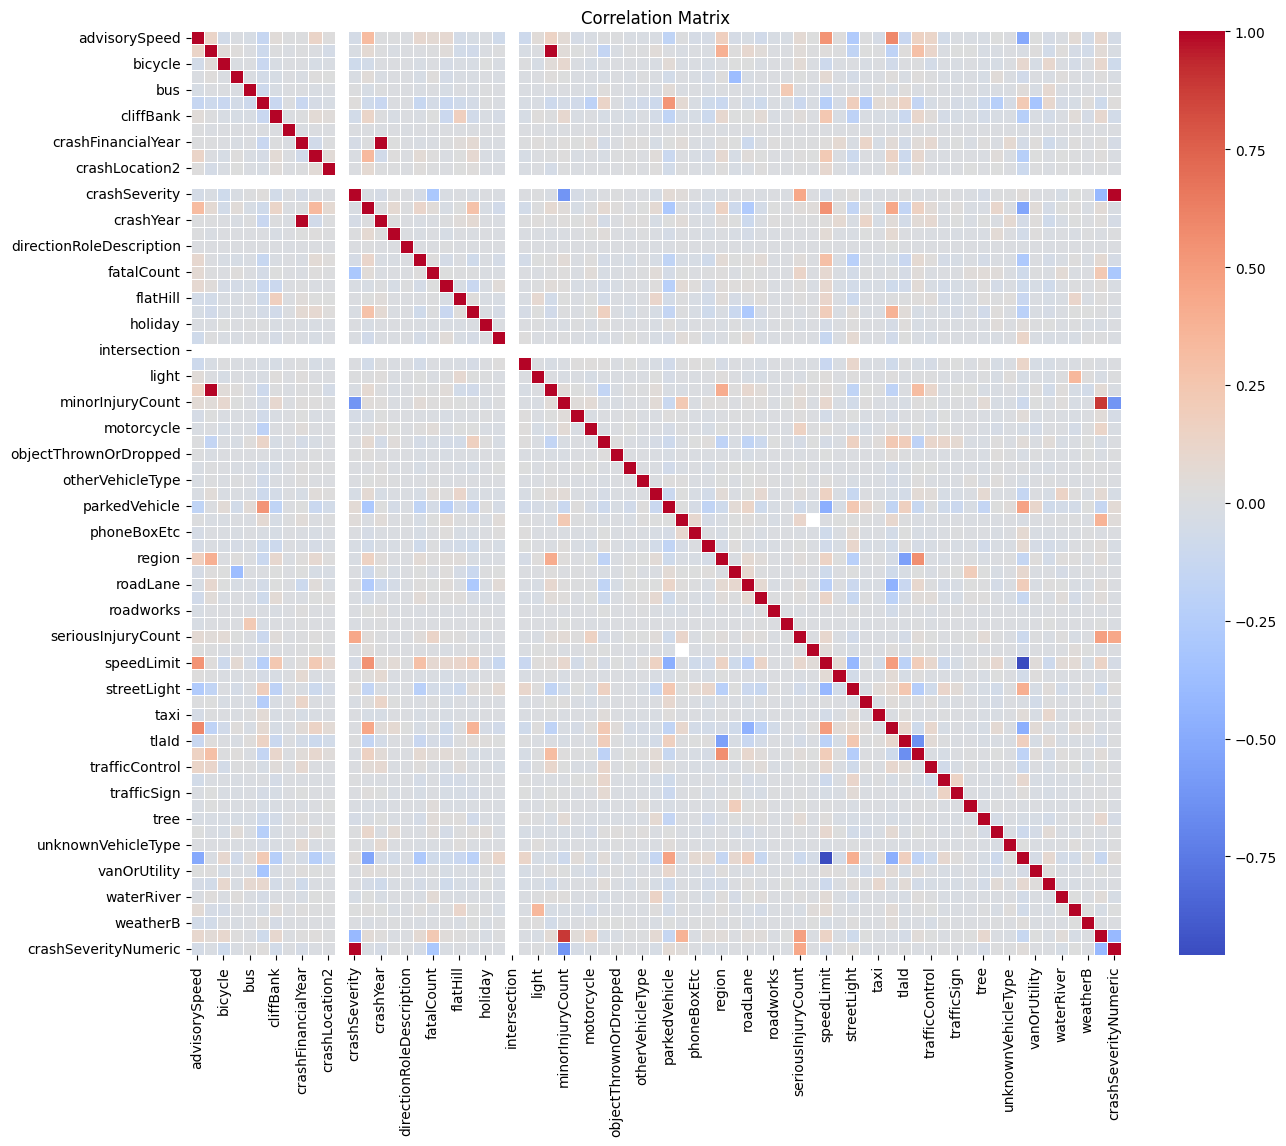

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt


correlation_matrix = df.corr()


plt.figure(figsize=(15, 12))  
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Targeted Insights for Clustering
From this corelation matrix the highly variable and correlated features are considered for clustering  ( DBSCAN or Fuzzy C-Means) 

Features like light, roadSurface, and speedLimit are likely to vary significantly and correlate with crash severity.

In [27]:
df.head()

,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,crashDirectionDescription,crashFinancialYear,crashLocation1,...,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB,totalInjuries,crashSeverityNumeric
0,NaN,538820.0,0.0,0.0,0.0,1.0,0.0,3,1,26993,...,0.0,0.0,1,0.0,0.0,0.0,2,2,1.0,1
1,NaN,549602.0,0.0,0.0,0.0,2.0,0.0,3,1,23460,...,0.0,0.0,0,1.0,0.0,0.0,3,2,1.0,1
2,NaN,528800.0,0.0,NaN,0.0,2.0,NaN,2,1,9525,...,0.0,0.0,1,0.0,NaN,NaN,0,2,4.0,1
3,NaN,523911.0,0.0,0.0,0.0,1.0,0.0,1,0,18553,...,0.0,0.0,0,0.0,0.0,0.0,0,2,1.0,1
4,NaN,545842.0,0.0,NaN,0.0,1.0,NaN,0,1,19874,...,0.0,0.0,0,1.0,NaN,NaN,0,2,2.0,3


Machine learning models

Random Forest Regression

In [28]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(df.drop('fatalCount', axis=1),
                                                    df.fatalCount, test_size=0.33, random_state=42)

In [29]:
#shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((573703, 70), (282571, 70), (573703,), (282571,))

In [30]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train),
           m.score(X_test, y_test)]

    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)

In [38]:
f_imp = pd.DataFrame(data={'importance':m.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp.head(10)


,importance
features,
tlaName,0.151515
crashSeverityNumeric,0.121212
overBank,0.121212
kerb,0.121212
temporarySpeedLimit,0.060606
crashDirectionDescription,0.060606
crashFinancialYear,0.060606
crashSeverity,0.060606
crashYear,0.030303


<Axes: xlabel='features'>

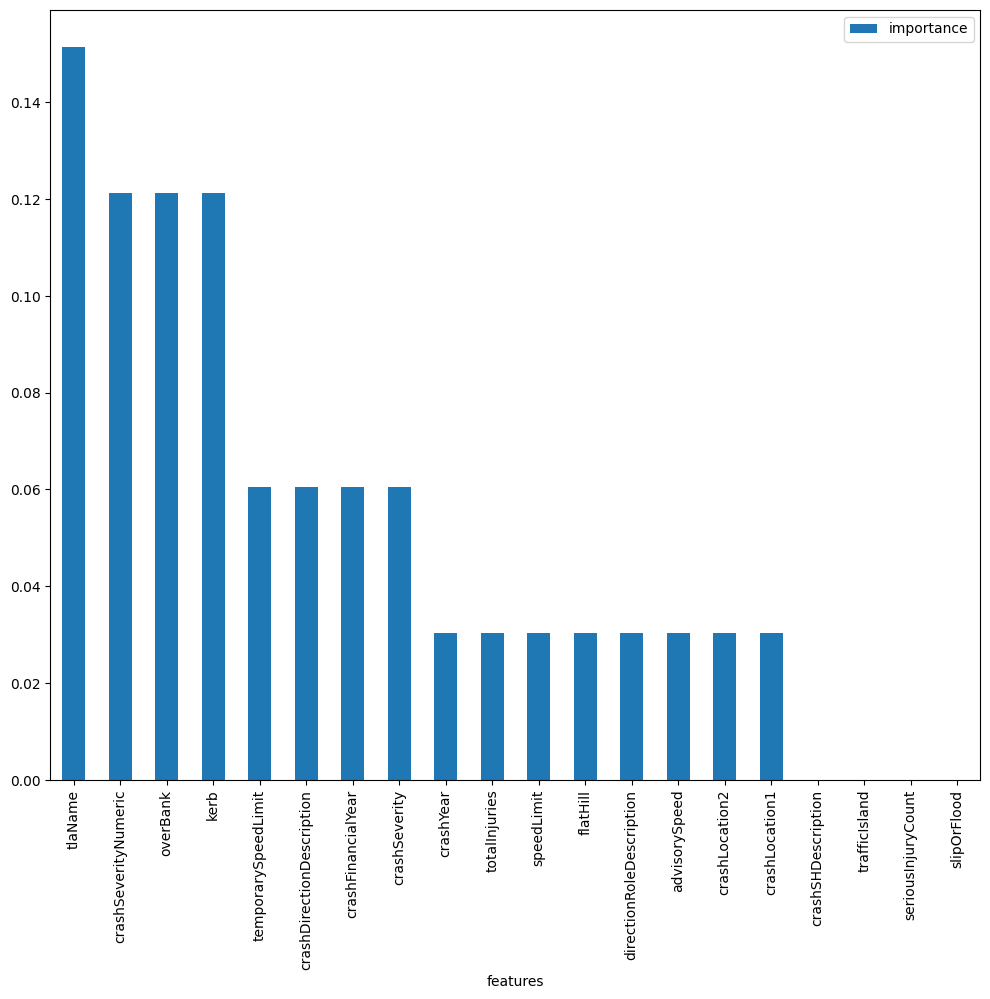

In [39]:
f_imp[:20].plot(kind='bar', figsize=(12,10))


In [40]:
f_imp_sel = f_imp[f_imp['importance'] > 0.0001]

In [41]:
len(f_imp_sel.index), len(f_imp.index)

(16, 70)

In [42]:
y = df.fatalCount

In [43]:
df_imp = df[f_imp_sel.index]
df_imp.shape

(856274, 16)

In [44]:
# again splitting of data after finding important features
X_train, X_test, y_train, y_test = train_test_split(df_imp, y, test_size=0.33, random_state=42)

In [45]:

train_data = pd.concat([X_train, y_train], axis=1)


train_data = train_data.dropna(subset=[train_data.columns[-1]])


X_train = train_data.iloc[:, :-1]  
y_train = train_data.iloc[:, -1]  


print(X_train.isnull().sum().sum())  
print(y_train.isnull().sum())      


1794674
0


In [46]:
print(y_train.dtype)

float64


In [47]:
y_train = pd.to_numeric(y_train, errors='coerce')

In [48]:
m = RandomForestRegressor(n_estimators=50, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, oob_score=True)

In [54]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5, min_samples_split=0.1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0444280420211181, 0.051452249015778724, 0.852966614043325, 0.8128941222850468, 0.8515966891127785]


Gradient Boost Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np



def print_score_gbr(m):
    res = [
        rmse(m.predict(X_train), y_train), 
        rmse(m.predict(X_test), y_test),   
        m.score(X_train, y_train),         
        m.score(X_test, y_test)            
    ]
    print("Gradient Boosting Regression Metrics:")
    print(f"Train RMSE: {res[0]:.4f}")
    print(f"Test RMSE: {res[1]:.4f}")
    print(f"Train R²: {res[2]:.4f}")
    print(f"Test R²: {res[3]:.4f}")
    return res

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

gbr = GradientBoostingRegressor(
    n_estimators=300,       
    learning_rate=0.05,    
    max_depth=4,           
    min_samples_split=10,   
    min_samples_leaf=5,    
    subsample=0.9,          
    max_features='sqrt',   
    random_state=42        
)


gbr.fit(X_train, y_train)


print_score_gbr(gbr)


Gradient Boosting Regression Metrics:
Train RMSE: 0.0355
Test RMSE: 0.0442
Train R²: 0.9060
Test R²: 0.8621


[0.03551672327564369,
 0.04417002508713375,
 0.9060347240180113,
 0.8621096110159782]

Clustering techniques--->DBSCAN Clustering and Fuzzy C Means Clustering

DBSCAN Clustering

eps=0.3, min_samples=3, Silhouette Score: 0.16059007652872423
eps=0.3, min_samples=5, Silhouette Score: 0.16249374183974508
eps=0.3, min_samples=10, Silhouette Score: 0.22320202124437455
eps=0.3, min_samples=15, Silhouette Score: 0.23875091649892974
eps=0.5, min_samples=3, Silhouette Score: 0.41131070760388283
eps=0.5, min_samples=5, Silhouette Score: 0.4112622211698568
eps=0.5, min_samples=10, Silhouette Score: 0.4260836277076967
eps=0.5, min_samples=15, Silhouette Score: 0.4266832287154283
eps=0.7, min_samples=3, Silhouette Score: 0.6494875555762404
eps=0.7, min_samples=5, Silhouette Score: 0.6496476153567025
eps=0.7, min_samples=10, Silhouette Score: 0.6496476153567025
eps=0.7, min_samples=15, Silhouette Score: 0.6437769012930136
eps=0.9, min_samples=5, Silhouette Score: 0.6999112830021699
eps=0.9, min_samples=15, Silhouette Score: 0.647520505113842
Best Silhouette Score: 0.6999112830021699 with eps=0.9 and min_samples=5


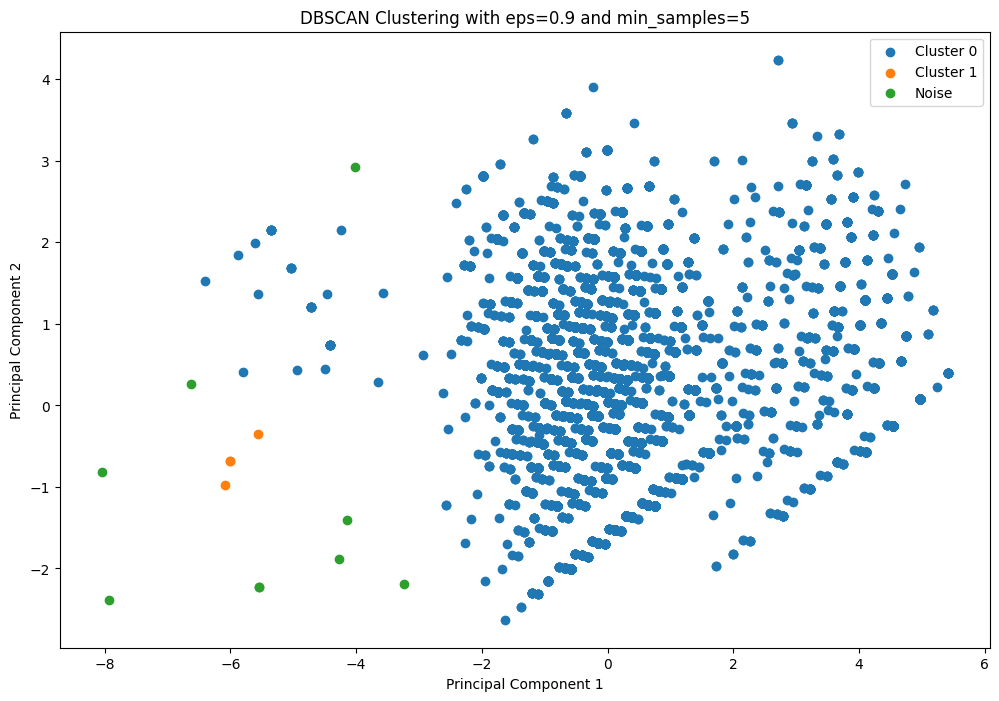

Cluster Insights (Feature Means by Cluster):
         speedLimit  crashSeverity     light  roadSurface   holiday
Cluster                                                            
-1        71.111111       2.111111  0.888889     0.444444  1.333333
 0        69.577675       1.805864  1.046677     2.031465  1.041904
 1       100.000000       1.750000  1.750000     0.000000  0.250000


In [56]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


selected_features = [
    'speedLimit',       
    'crashSeverity',    
    'light',            
    'roadSurface',      
    'holiday'           
]


filtered_data = gdf[selected_features].dropna()


categorical_columns = ['crashSeverity', 'light', 'roadSurface', 'holiday']
for col in categorical_columns:
    if col in filtered_data.columns:
        filtered_data[col] = filtered_data[col].astype('category').cat.codes


scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data)


pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)



eps_values = [0.3, 0.5, 0.7, 0.9, 1.2]  
min_samples_values = [3, 5, 10, 15]  
best_silhouette = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_pca)

       
        unique_labels = set(cluster_labels)
        if len(unique_labels) > 1 and -1 in unique_labels:
            
            filtered_data_for_silhouette = X_pca[cluster_labels != -1]
            cluster_labels_for_silhouette = cluster_labels[cluster_labels != -1]

            if len(set(cluster_labels_for_silhouette)) > 1:
                silhouette_avg = silhouette_score(
                    filtered_data_for_silhouette, cluster_labels_for_silhouette
                )
                print(f"eps={eps}, min_samples={min_samples}, Silhouette Score: {silhouette_avg}")
                if silhouette_avg > best_silhouette:
                    best_silhouette = silhouette_avg
                    best_eps = eps
                    best_min_samples = min_samples


if best_eps is not None and best_min_samples is not None:
    print(f"Best Silhouette Score: {best_silhouette} with eps={best_eps} and min_samples={best_min_samples}")

    
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    cluster_labels = dbscan.fit_predict(X_pca)

    plt.figure(figsize=(12, 8))
    unique_labels = set(cluster_labels)
    for label in unique_labels:
        if label == -1:  
            color = 'k'
            label_name = 'Noise'
        else:
            color = plt.cm.Spectral(label / len(unique_labels))
            label_name = f'Cluster {label}'
        plt.scatter(
            X_pca[cluster_labels == label, 0],
            X_pca[cluster_labels == label, 1],
            label=label_name
        )

    plt.title(f'DBSCAN Clustering with eps={best_eps} and min_samples={best_min_samples}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    
    filtered_data['Cluster'] = cluster_labels
    print("Cluster Insights (Feature Means by Cluster):")
    cluster_insights = filtered_data.groupby('Cluster').mean()
    print(cluster_insights)
else:
    print("No valid clustering was found. Consider expanding the hyperparameter ranges.")


Traing Random Forest Regression model again using analysis from DBSCAN clustering

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd


X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])


X_train = X_train.drop(columns=X_train.columns[X_train.isnull().all()], errors='ignore')
X_test = X_test.drop(columns=X_test.columns[X_test.isnull().all()], errors='ignore')


imputer = SimpleImputer(strategy='mean')  
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_imputed)

# using DBSCAN analysis
dbscan = DBSCAN(eps=0.9, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Adding DBSCAN cluster labels as a new feature
X_train['cluster'] = dbscan_labels
X_test['cluster'] = dbscan.fit_predict(scaler.transform(X_test_imputed)) 


X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train_filtered = X_train[X_train['cluster'] != -1].reset_index(drop=True)
y_train_filtered = y_train[X_train['cluster'] != -1].reset_index(drop=True)


rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    oob_score=True, 
    min_samples_leaf=5  
)
rf.fit(X_train_filtered, y_train_filtered)


y_pred_train = rf.predict(X_train_filtered)
y_pred_test = rf.predict(X_test)


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train_filtered, y_pred_train, squared=False) 
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train_filtered, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)


print("Random Forest Regression with DBSCAN Cluster Feature:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


Random Forest Regression with DBSCAN Cluster Feature:
Train RMSE: 0.0058
Test RMSE: 0.0484
Train R²: 0.9561
Test R²: 0.8342


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:

rf = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    oob_score=True,  
    min_samples_leaf=5  
)


rf.fit(X_train_filtered, y_train_filtered)


y_pred_train = rf.predict(X_train_filtered)
y_pred_test = rf.predict(X_test)


train_rmse = mean_squared_error(y_train_filtered, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train_filtered, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)


print("Random Forest Regression with DBSCAN Cluster Feature:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


print(f"OOB Score: {rf.oob_score_:.4f}")


Random Forest Regression with DBSCAN Cluster Feature:
Train RMSE: 0.0058
Test RMSE: 0.0484
Train R²: 0.9561
Test R²: 0.8342
OOB Score: 0.9221


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fuzzy C Means Clustering

In [57]:
!pip install scikit-fuzzy



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


n_clusters=6, m=1.1, Silhouette Score: 0.43432194672781543
n_clusters=7, m=1.1, Silhouette Score: 0.42465589006903165
n_clusters=8, m=1.1, Silhouette Score: 0.4199571792739476
n_clusters=6, m=1.05, Silhouette Score: 0.4343361399790689
n_clusters=7, m=1.05, Silhouette Score: 0.41529213378536134
n_clusters=8, m=1.05, Silhouette Score: 0.41931089120369747
Best Silhouette Score: 0.4343361399790689 with n_clusters=6 and m=1.05


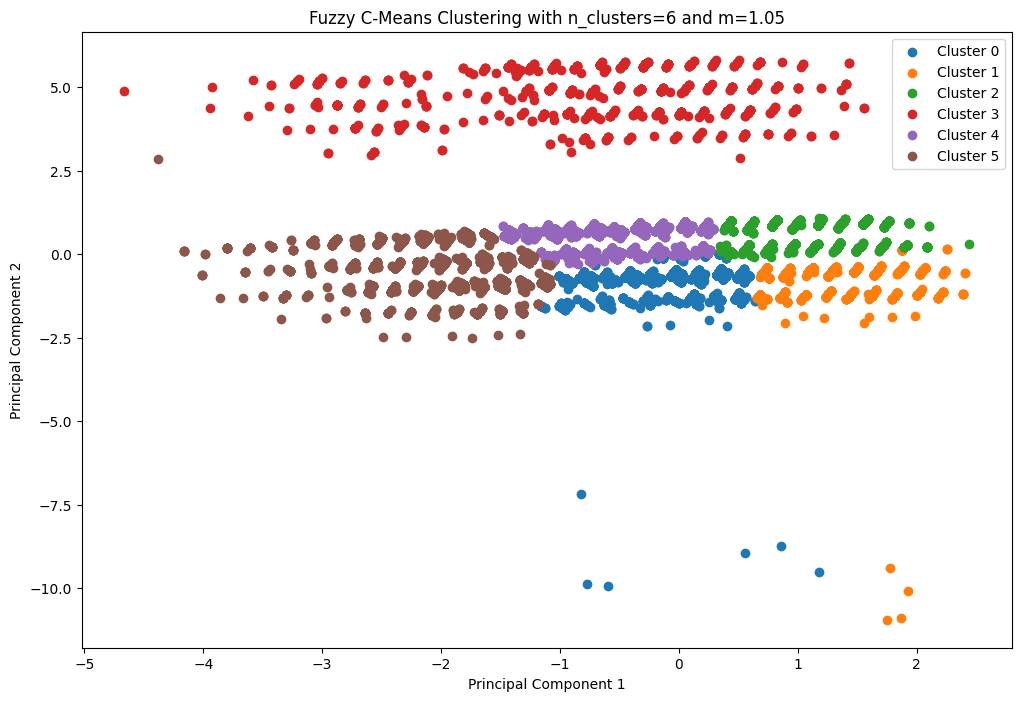

Cluster Insights (Feature Means by Cluster):
         speedLimit  crashSeverity     light  advisorySpeed  roadSurface
Cluster                                                                 
0         93.040587       1.836971  2.055252      47.113745     1.998124
1         99.825104       1.647733  2.103854      70.813342     1.998762
2         99.654080       1.701343  0.605423      70.637354     2.000000
3         90.048721       1.803898  1.032887      46.199756     3.000000
4         93.020725       1.865458  0.490501      44.297927     2.000000
5         52.011345       1.839708  1.146353      33.974068     2.000162
Fuzzy Partition Coefficient (FPC) for 6 clusters: 0.9953486441350832


In [58]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



selected_features = [
    'speedLimit',       
    'crashSeverity',    
    'light',            
    'advisorySpeed',    
    'roadSurface'      
]


filtered_data = gdf[selected_features].dropna()


categorical_columns = ['crashSeverity', 'light', 'roadSurface']
for col in categorical_columns:
    if col in filtered_data.columns:
        filtered_data[col] = filtered_data[col].astype('category').cat.codes


scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data)


pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_scaled)


m_values = [1.1, 1.05]  
n_clusters_options = [6, 7, 8]  
best_silhouette = -1
best_m = None
best_n_clusters = None

for m in m_values:
    for n_clusters in n_clusters_options:
        
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            X_pca.T,  
            n_clusters,  
            m=m,  
            error=0.005,  
            maxiter=1000,  
            init=None  
        )

        
        cluster_membership = np.argmax(u, axis=0)

   
        if len(set(cluster_membership)) > 1:
            silhouette_avg = silhouette_score(X_pca, cluster_membership)
            print(f"n_clusters={n_clusters}, m={m}, Silhouette Score: {silhouette_avg}")
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_m = m
                best_n_clusters = n_clusters


print(f"Best Silhouette Score: {best_silhouette} with n_clusters={best_n_clusters} and m={best_m}")


cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_pca.T, best_n_clusters, m=best_m, error=0.005, maxiter=1000, init=None
)
cluster_membership = np.argmax(u, axis=0)

plt.figure(figsize=(12, 8))
for i in range(best_n_clusters):
    plt.scatter(
        X_pca[cluster_membership == i, 0],
        X_pca[cluster_membership == i, 1],
        label=f'Cluster {i}'
    )
plt.title(f'Fuzzy C-Means Clustering with n_clusters={best_n_clusters} and m={best_m}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


filtered_data['Cluster'] = cluster_membership
print("Cluster Insights (Feature Means by Cluster):")
cluster_insights = filtered_data.groupby('Cluster').mean()
print(cluster_insights)


print(f"Fuzzy Partition Coefficient (FPC) for {best_n_clusters} clusters: {fpc}")
